In [1]:
import lightgbm as lgb
import sys
from os import listdir
from os.path import isdir, isfile, join
import os.path
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.externals import joblib
import matplotlib.pyplot as plt


In [2]:
def readCSVfromDirectory(dir):
    print(dir)
    filepaths = []
    for f in listdir(dir):
        path = join(dir, f)
        if isfile(path) and f.endswith(".csv"):
            filepaths.append(path)

    if len(filepaths) == 0:
        exit("Directory does not contain any csv files: %s" % dir)

    filepaths = np.sort(filepaths)
    print("Found %s files." % len(filepaths))

    return filepaths


In [3]:
#############################################
#MARK: - Read Files

SOURCE_DIR = "./data/"


SOURCE_DIR = os.path.abspath(SOURCE_DIR)
if not isdir(SOURCE_DIR):
    exit("That's not a directory!")
else:
    print(SOURCE_DIR)

elems = listdir(SOURCE_DIR)
print(elems)
directories = {}
for e in elems:
    path = join(SOURCE_DIR, e)
    
    if isdir(path):
        filepaths = readCSVfromDirectory(path)

        directories[e] = []
        for filepath in filepaths:
            # the files contain values in [V] and [A]
            # use a current Factor of 10e-3 if given in [mA]
            dataframe = pd.read_csv(filepath, header=1)
            # Felix ist schuld
            dataframe.columns = dataframe.columns.str.strip().str.replace('(', '').str.replace(')', '') 
            #create id field
            dataframe = dataframe.assign(id= lambda x: dataframe.index )
            #remove ms field
            dataframe = dataframe.drop(columns=['ms'])
            if 'mA' in dataframe:
                dataframe = dataframe.assign(A= lambda x: x.mA / 1000)
                dataframe = dataframe.drop(columns=['mA'])
                #print("Converted mA to A")
            directories[e].append(dataframe)
            

/Users/paul/DataScienceProjekt/data
['ohp_voll-single.psdata', 'laptop-single', 'ohp_voll-laptop', 'lampe-ohp_voll.psdata', 'ohp_halb-single', 'ohp_halb-single.psdata', 'ohp_voll-laptop-bosch-lampe.psdata', 'lampe-ohp_voll', 'ohp_voll-single', 'ohp_halb-laptop-lampe.psdata', 'ohp_halb-laptop.psdata', 'bosch-single', 'lampe-single', 'ohp_voll-laptop-bosch-lampe', 'ohp_halb-laptop', 'ohp_halb-laptop-lampe']
/Users/paul/DataScienceProjekt/data/laptop-single
Found 256 files.
/Users/paul/DataScienceProjekt/data/ohp_voll-laptop
Found 256 files.
/Users/paul/DataScienceProjekt/data/ohp_halb-single
Found 256 files.
/Users/paul/DataScienceProjekt/data/lampe-ohp_voll
Found 256 files.
/Users/paul/DataScienceProjekt/data/ohp_voll-single
Found 256 files.
/Users/paul/DataScienceProjekt/data/bosch-single
Found 256 files.
/Users/paul/DataScienceProjekt/data/lampe-single
Found 256 files.
/Users/paul/DataScienceProjekt/data/ohp_voll-laptop-bosch-lampe
Found 256 files.
/Users/paul/DataScienceProjekt/data/

In [4]:
for (id, dfs) in directories.items():
    print(id, len(dfs))
    print(dfs[0].head(4))
    print(dfs[0].describe())
    print('\n\n')

laptop-single 256
          V         A  id
0 -8.224738  0.018067   0
1 -8.224738  0.036012   1
2 -3.753777  0.018067   2
3  0.732444  0.018067   3
                 V            A           id
count  2445.000000  2445.000000  2445.000000
mean     38.888648     0.021008  1222.000000
std     222.962687     0.338291   705.955027
min    -321.848200    -1.293191     0.000000
25%    -178.472200    -0.017823   611.000000
50%      81.362350     0.000122  1222.000000
75%     251.609800     0.018067  1833.000000
max     314.340600     1.419172  2444.000000



ohp_voll-laptop 256
           V         A  id
0 -12.710960 -1.078524   0
1  -8.224738 -1.078524   1
2  -3.753777 -1.078524   2
3  -8.224738 -1.078524   3
                 V            A           id
count  2445.000000  2445.000000  2445.000000
mean     38.879487     0.443960  1222.000000
std     221.681810     2.560982   705.955027
min    -317.362000    -5.035249     0.000000
25%    -174.001300    -1.887875   611.000000
50%      81.362350 

#### TODO

- Zeit diskretisieren 0ms = 0 und 20ms = 2445 (neue spalte -> id des datensatzes) done
- mA zu A umrechnen (falls vorhanden) done
- geht multilabel mit gradient boosting? jaein, vielleicht
- in X und Y aufteilen 
- attacke!


Showing: laptop-single


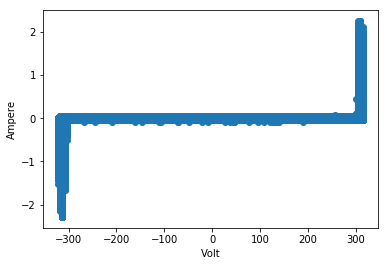

Showing: ohp_voll-laptop


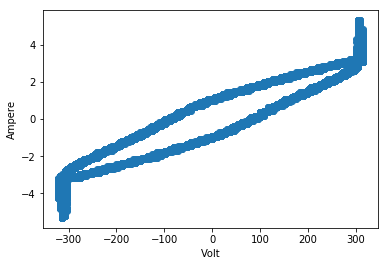

Showing: ohp_halb-single


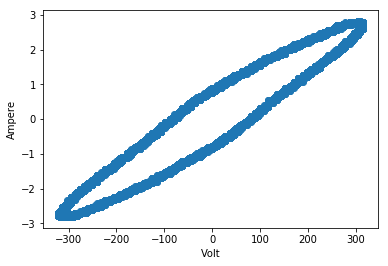

Showing: lampe-ohp_voll


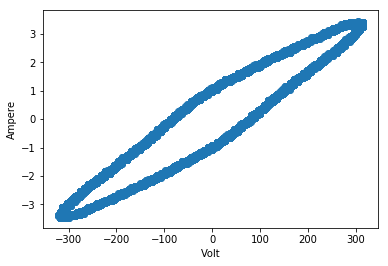

Showing: ohp_voll-single


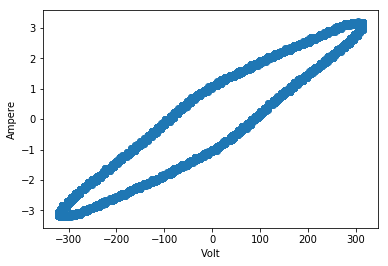

Showing: bosch-single


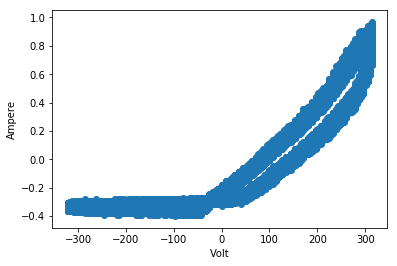

Showing: lampe-single


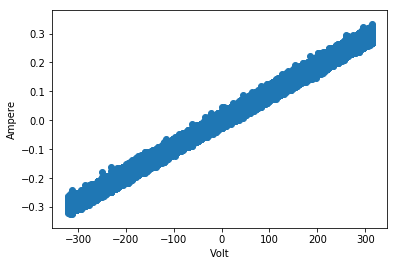

Showing: ohp_voll-laptop-bosch-lampe


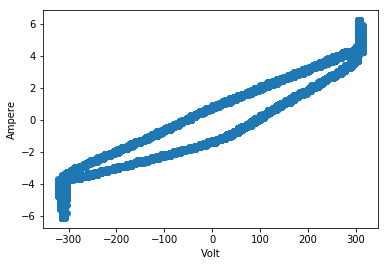

Showing: ohp_halb-laptop


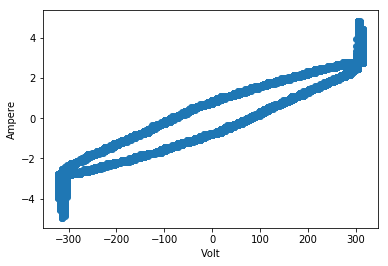

Showing: ohp_halb-laptop-lampe


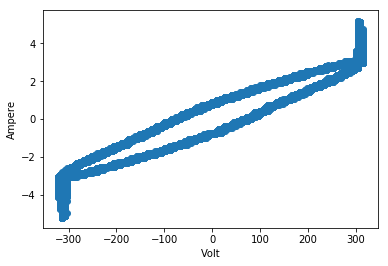

In [5]:
features = []

for label, data in directories.items():
    # pro gerät alle daten in einen dataframe
    res = pd.concat(data, sort=False)
    #zu der tabelle eine spalte mit label hinzufügen
    res = res.assign(labels= lambda x: label)
    _ = plt.scatter(res['V'], res['A'])
    _ = plt.xlabel("Volt")
    _ = plt.ylabel("Ampere")
    print("Showing: " + label)
    plt.show()
    features.append(res)

# dataframes zu einem kombinieren
features = pd.concat(features, sort=False)

X = features.drop(columns=['labels'])
min_max_scaler = preprocessing.MinMaxScaler()
X = min_max_scaler.fit_transform(X)
Y = features['labels']

#print(X)

Y = pd.get_dummies(Y)
Y = Y.assign(labels= lambda x: 0 + x['lampe-ohp_voll'] + x['lampe-single'] * 2 + x['laptop-single'] * 3 + x['ohp_halb-laptop']* 4 + x['ohp_halb-laptop-lampe'] * 5 + x['ohp_halb-single'] * 6 + x['ohp_voll-laptop'] * 7 + x['ohp_voll-laptop-bosch-lampe'] * 8 + x['ohp_voll-single'] *9)
Y = Y['labels']


In [6]:
%matplotlib inline
from pandas.plotting import scatter_matrix
scatter_matrix(features, alpha=0.2, figsize=(20, 20), diagonal='kde')

In [7]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, shuffle=True)

In [8]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=50, random_state=42, min_samples_split=2, n_jobs=-1, verbose=2)
clf.fit(X_train, Y_train)

building tree 1 of 50
building tree 2 of 50
building tree 3 of 50building tree 4 of 50

building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  4.5min


building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 of 50
building tree 47 of 50
building tree 48 of 50
building tree 49 of 50
building tree 50 of 50


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  6.2min finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=-1,
            oob_score=False, random_state=42, verbose=2, warm_start=False)

In [9]:
print("Train:", round(10000*clf.score(X_train, Y_train))/100.0)
print("Test:", round(10000*clf.score(X_test, Y_test))/100.0)

[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   28.6s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:   40.3s finished


Train: 90.66


[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    6.4s


Test: 90.39


[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:   10.3s finished


In [10]:
joblib.dump(clf, 'trainedModelforFelixandDatascienceProject_longFilenamecausewerecool.pkl') 

['trainedModelforFelixandDatascienceProject_longFilenamecausewerecool.pkl']